In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def conc(vects):
    x, y = vects
    conc1 = concatenate([x,y])
    return conc1

def conc_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],256)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    x = y_pred[:,0:128]
    y = y_pred[:,128:268]
    y_pred1 = euclidean_distance(x,y)
    p = x
    q = y
    p = K.clip(p, K.epsilon(), 1)
    q = K.clip(q, K.epsilon(), 1)
    #y_true1 = y_true[:,0]
    #y_true1 = K.reshape(y_true1,(-1,))
    #print(y_true1)
    #tr_same = y_true[:,1]
    #tr_same = K.reshape(tr_same, (-1,))
    y_true1 = y_true
    tr_same = K.round(y_true/3)
    margin = 1
    test = 0.001*K.sum(p*K.abs(K.log(p)-K.log(q)), axis=1)

    return K.mean((1-tr_same)*(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))
                 + (tr_same)*test)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    for i in range(0,10):
        for j in range(201,231):
            img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
            arr = np.array(img)
            arr = arr.ravel()
            d = i*100+j*10
            for k in range(0,100):
                pairs+=[[x[k+d], arr]]
                labels += [3]
    return np.array(pairs), np.array(labels)

def create_addi_pairs(mnist):
    pairs = []
    labels = []
    for i in range(0,10):
        for j in range(201,216):
            img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
            arr = np.array(img)
            arr = arr.ravel()
            d = i*100+j*10
            for k in range(0,100):
                pairs+=[[mnist[k+d], arr]]
                labels += [3]
    return np.array(pairs), np.array(labels)
            
            


def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.2))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq



def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.epsilon()

1e-07

In [3]:
seed=7
numpy.random.seed(seed)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [5]:
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [6]:
X_train=X_train/255
X_test=X_test/255

In [7]:
print(y_train)

[5 0 4 ... 5 6 8]


In [8]:
input_dim = 784
nb_epoch = 20

In [9]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [10]:
print(tr_pairs.shape)
print(te_pairs.shape)

(138400, 2, 784)
(47820, 2, 784)


In [21]:
base_network = create_base_network()

In [12]:

X_temp=X_train.reshape(-1,28,28,1)
input_dim = X_temp.shape[1:]
print(input_dim)

(28, 28, 1)


In [22]:

# network definition
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 28, 28, 1)


In [23]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc, output_shape=conc_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  


In [24]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [16]:
tr_pairs1=tr_pairs.reshape(-1,2,28,28,1)
te_pairs1=te_pairs.reshape(-1,2,28,28,1)

print(tr_pairs1.shape)
print(te_pairs1.shape)

(138400, 2, 28, 28, 1)
(47820, 2, 28, 28, 1)


In [17]:
print(tr_pairs1[:,0].shape)

(138400, 28, 28, 1)


In [18]:
print(tr_pairs[:, 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


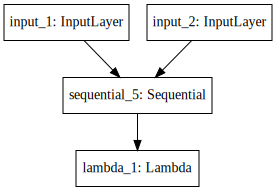

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

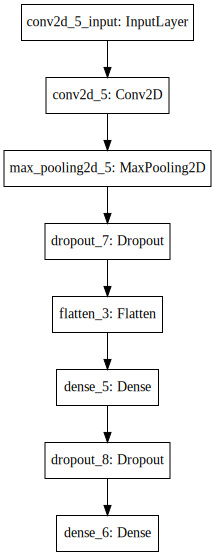

In [39]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [25]:
nb_epoch=3

In [36]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
history = model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 138400 samples, validate on 47820 samples
Epoch 1/5
138400/138400 [==============================] - 122s 884us/step - loss: 0.0469 - val_loss: 0.0246
Epoch 2/5
138400/138400 [==============================] - 118s 849us/step - loss: 0.0179 - val_loss: 0.0219
Epoch 3/5
138400/138400 [==============================] - 118s 850us/step - loss: 0.0134 - val_loss: 0.0205
Epoch 4/5
138400/138400 [==============================] - 118s 852us/step - loss: 0.0115 - val_loss: 0.0202
Epoch 5/5
138400/138400 [==============================] - 118s 850us/step - loss: 0.0104 - val_loss: 0.0196


In [26]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
history = model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 138400 samples, validate on 47820 samples
Epoch 1/3
138400/138400 [==============================] - 138s 996us/step - loss: 0.0465 - val_loss: 0.0220
Epoch 2/3
138400/138400 [==============================] - 140s 1ms/step - loss: 0.0183 - val_loss: 0.0199
Epoch 3/3
138400/138400 [==============================] - 145s 1ms/step - loss: 0.0142 - val_loss: 0.0185


In [26]:
model.save('Siamese+Conv_Train-mnist_150usps_Test-usps.hf')

In [49]:
model.save('Siamese+Conv_Train-mnist_150usps_Test-usps.h5')

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [28]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs1[:,0], tr_pairs1[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs1[:,0], te_pairs1[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.98%
* Accuracy on test set: 99.88%


In [28]:
y_test1=[]
for i in range(0,10):
    for j in range(300,1300):
        y_test1.append(i)
y_test1=np.array(y_test1)
print(y_test1.size)
print(y_test1)

10000
[0 0 0 ... 9 9 9]


In [29]:
X_test1=[]
for i in range(0,10):
    for j in range(300,1300):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_test1.append(arr)
X_test1=np.array(X_test1)
print(X_test1.shape)
print(X_test.shape)

(10000, 784)
(10000, 784)


In [30]:
X_test1 = X_test1.reshape(10000, 784)
X_test1 = X_test1.astype('float32')
X_test1 /= 255
print(X_test.shape)



(10000, 784)


In [31]:
te_pairs2=te_pairs.reshape(-1,2,28,28,1)

print(te_pairs2.shape)

(47820, 2, 28, 28, 1)


In [33]:
pred = model.predict([te_pairs2[:, 0], te_pairs2[:, 1]])
te_acc = compute_accuracy(pred, te_y)

# compute accuracy on new USPS dataset to check degree of transfer learning
# model only trained on MNIST dataset
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 90.96%


In [32]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [33]:
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [44]:
X_test1=X_test1.reshape(-1,28,28,1)

In [45]:
X_test = X_test.reshape(-1,28,28,1)
processed=test_model.predict(X_test)

In [34]:
X_test1 = X_test1.reshape(-1,28,28,1)
processed=test_model.predict(X_test1)

Computing t-SNE embedding


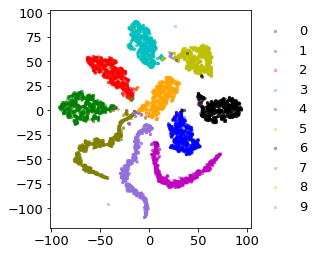

In [46]:
# with absolute value of kl divergence
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


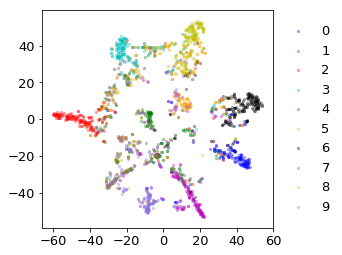

In [48]:
# with absolute value of kl divergence
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


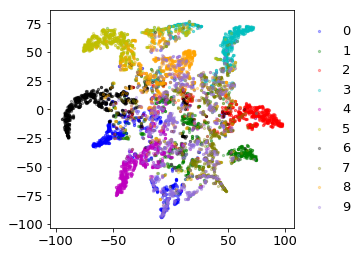

In [35]:
# with absolute value of kl divergence
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [36]:
X_train11=X_train.reshape(-1,28,28,1)
X_test11=X_test.reshape(-1,28,28,1)

In [37]:
processed_train=test_model.predict(X_train11)
processed_test=test_model.predict(X_test11)

In [38]:
num_pixels = 128
processed_train = processed_train.reshape(processed_train.shape[0], num_pixels).astype('float32')
processed_test = processed_test.reshape(processed_test.shape[0], num_pixels).astype('float32')

print(num_pixels)
print(processed_train.shape)
print(processed_test.shape)

128
(60000, 128)
(10000, 128)


In [39]:
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test)
num_classes = 10

In [40]:
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [41]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.7588 - acc: 0.9618 - val_loss: 0.0751 - val_acc: 0.9876
Epoch 2/10
 - 1s - loss: 0.0392 - acc: 0.9936 - val_loss: 0.0472 - val_acc: 0.9879
Epoch 3/10
 - 1s - loss: 0.0283 - acc: 0.9938 - val_loss: 0.0431 - val_acc: 0.9883
Epoch 4/10
 - 1s - loss: 0.0262 - acc: 0.9938 - val_loss: 0.0425 - val_acc: 0.9882
Epoch 5/10
 - 1s - loss: 0.0253 - acc: 0.9940 - val_loss: 0.0426 - val_acc: 0.9882
Epoch 6/10
 - 1s - loss: 0.0249 - acc: 0.9940 - val_loss: 0.0416 - val_acc: 0.9885
Epoch 7/10
 - 1s - loss: 0.0245 - acc: 0.9942 - val_loss: 0.0412 - val_acc: 0.9884
Epoch 8/10
 - 1s - loss: 0.0242 - acc: 0.9942 - val_loss: 0.0414 - val_acc: 0.9885
Epoch 9/10
 - 1s - loss: 0.0241 - acc: 0.9944 - val_loss: 0.0414 - val_acc: 0.9884
Epoch 10/10
 - 1s - loss: 0.0238 - acc: 0.9944 - val_loss: 0.0401 - val_acc: 0.9893
60000/60000 [==============================] - 1s 24us/step


In [42]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.44%
* Accuracy on test set: 98.93%


In [43]:
y_test2=[]
for i in range(0,10):
    for j in range(300,1300):
        y_test2.append(i)
y_test2=np.array(y_test2)
print(y_test2.size)

10000


In [44]:
from keras.utils import np_utils
y_test2 = np_utils.to_categorical(y_test2)
num_classes = 10

In [45]:
scores_test_USPS=model1.evaluate(processed, y_test2, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

10000/10000 [==============================] - 0s 27us/step
* Accuracy on test USPS set: 63.24%
